In [29]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import caffe
import utils

from ipywidgets import interact

# matplotlib config
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['image.interpolation'] = 'nearest'
plt.rcParams['image.cmap'] = 'gray'

caffe.set_device(0)
caffe.set_mode_gpu()

ITERS = 40000

True category is: /a/aquarium
Predicted class is /a/aquarium

/a/aquarium (p=0.639095366001)
/i/iceberg (p=0.0800863206387)
/v/volcano (p=0.050836391747)
/c/coast (p=0.025221388787)
/h/hot_spring (p=0.0251510292292)


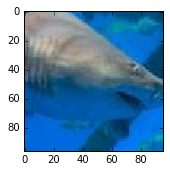

In [30]:
@interact
def predict(i=(0, 1000)):
    labels = utils.load_labels()

    # load network
    net, transformer = utils.load_net(ITERS, i, labels)

    # compute predictions
    out = net.forward()
    probs = out['probs'][0]
    print("Predicted class is {}\n".format(labels[probs.argmax()]))
    
    # sort top k predictions from softmax output
    top_k = probs.argsort()[::-1][:5]
    categories = labels[top_k]
    for cat, p in zip(categories, probs[top_k]):
        print("{} (p={})".format(cat, p))
    
    image = transformer.deprocess('data', net.blobs['data'].data[0])
    plt.imshow(image)
    fig = plt.gcf()
    fig.set_size_inches(2.5, 2.5)

    return net

True category is: /f/fountain
Predicted class is /r/railroad_track

/r/railroad_track (p=0.213753968477)
/t/trench (p=0.108442604542)
/c/construction_site (p=0.0695816203952)
/s/slum (p=0.059100035578)
/p/playground (p=0.0454460717738)


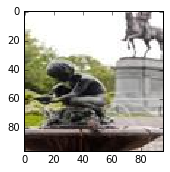

In [31]:
net = predict(27)

Helper functions for visualization

In [32]:
for layer, blob in net.blobs.iteritems():
    print("{} {}".format(layer, tuple(blob.shape)))

data (1, 3, 96, 96)
ignored_label (1,)
conv1 (1, 54, 45, 45)
norm1 (1, 54, 45, 45)
pool1 (1, 54, 22, 22)
conv2 (1, 128, 10, 10)
norm2 (1, 128, 10, 10)
pool2 (1, 128, 5, 5)
conv3 (1, 128, 5, 5)
conv4 (1, 128, 5, 5)
conv5 (1, 128, 5, 5)
pool5 (1, 128, 2, 2)
fc6 (1, 512)
fc7 (1, 128)
fc8 (1, 100)
probs (1, 100)


In [33]:
for layer, params in net.params.iteritems():
    print("{} {}".format(layer, params[0].data.shape))

conv1 (54, 3, 7, 7)
conv2 (128, 27, 5, 5)
conv3 (128, 128, 3, 3)
conv4 (128, 64, 3, 3)
conv5 (128, 64, 3, 3)
fc6 (512, 512)
fc7 (128, 512)
fc8 (100, 128)


## Layer 1

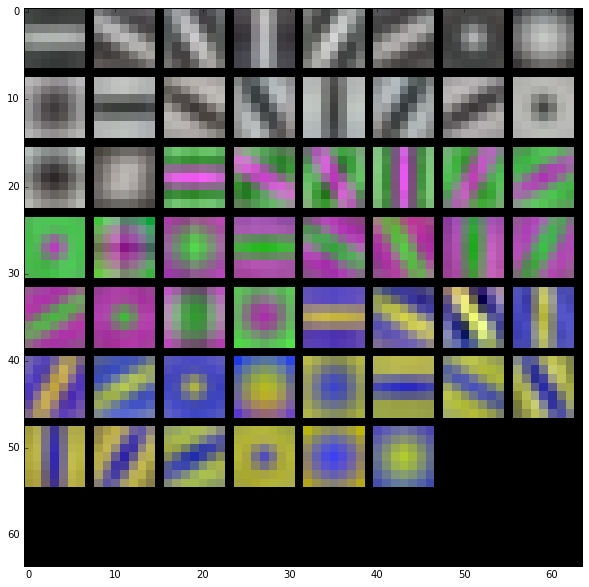

In [34]:
# the parameters are a list of [weights, biases]
filters = net.params['conv1'][0].data
utils.vis_square(filters.transpose(0, 2, 3, 1))

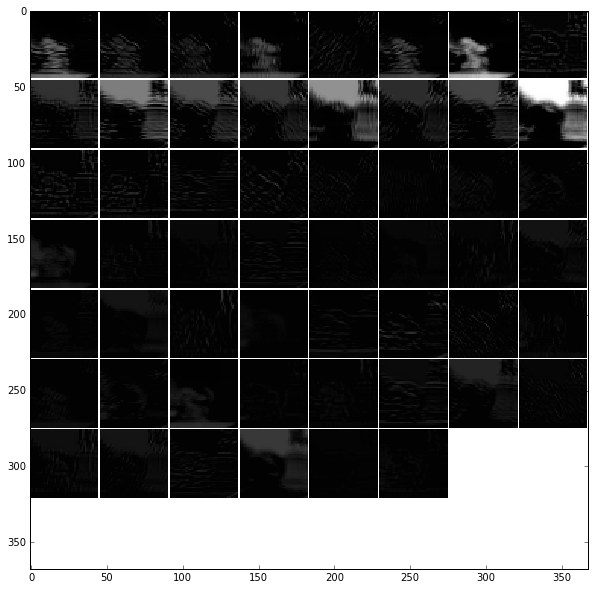

In [8]:
feat = net.blobs['conv1'].data[0]
utils.vis_square(feat, padval=1)

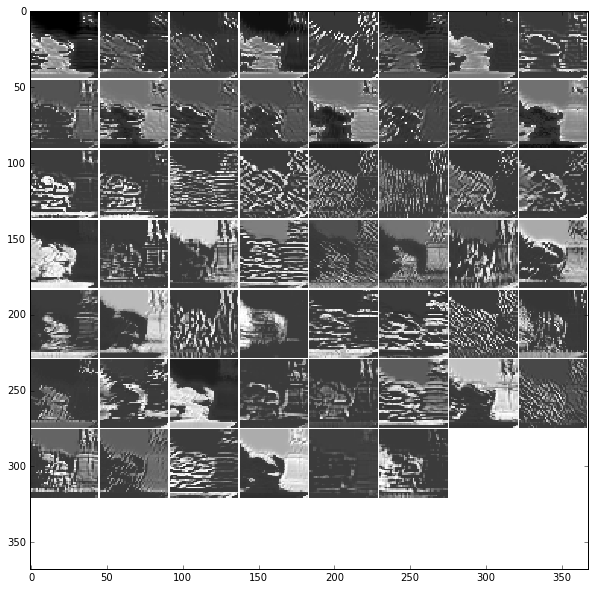

In [9]:
feat = net.blobs['norm1'].data[0]
utils.vis_square(feat, padval=1)

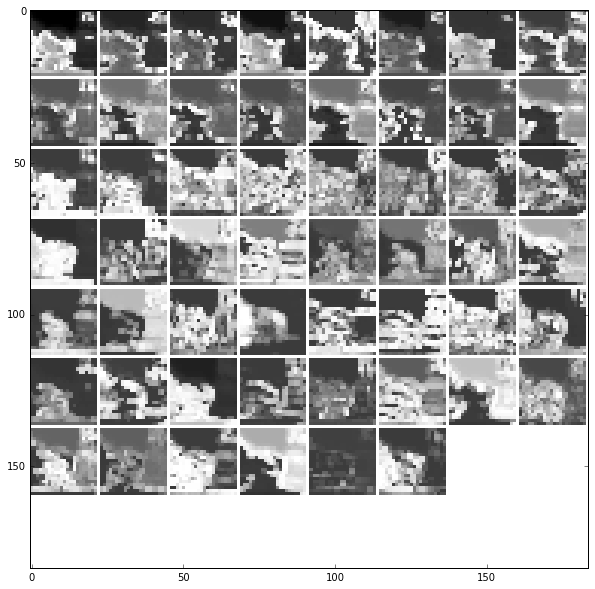

In [10]:
feat = net.blobs['pool1'].data[0]
utils.vis_square(feat, padval=1)

## Layer 2

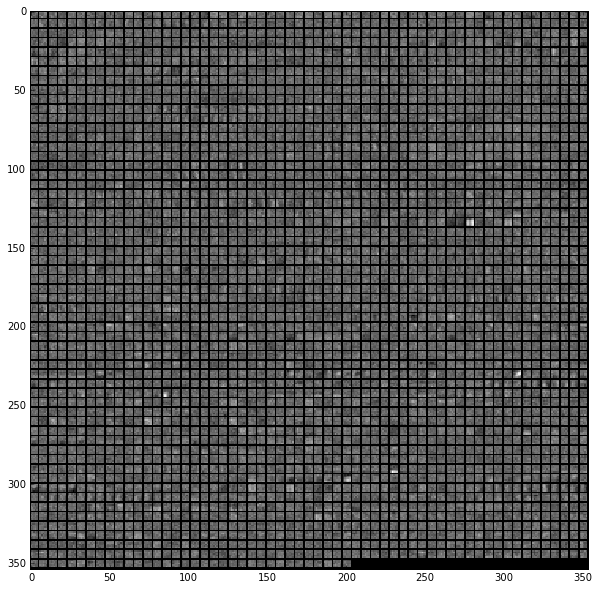

In [11]:
filters = net.params['conv2'][0].data
utils.vis_square(filters.reshape(128*27, 5, 5))

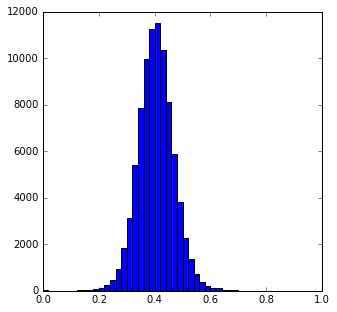

In [12]:
fig, ax = plt.subplots()
ax.hist(filters.ravel(), bins=50)
fig.set_size_inches(5, 5)

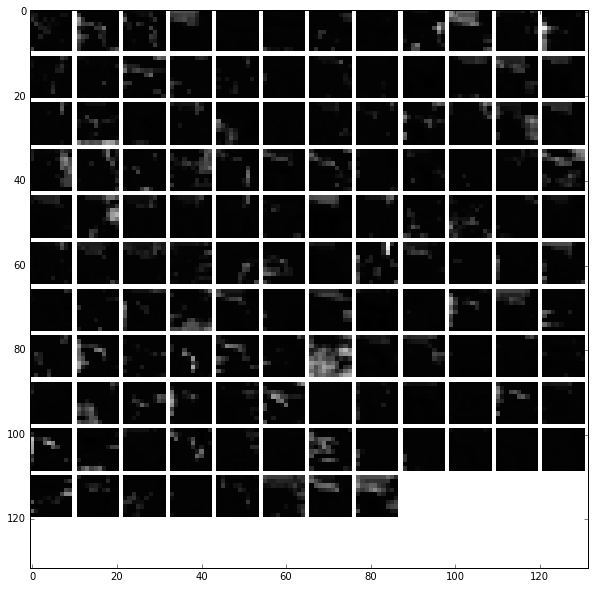

In [13]:
feat = net.blobs['conv2'].data[0]
utils.vis_square(feat, padval=1)

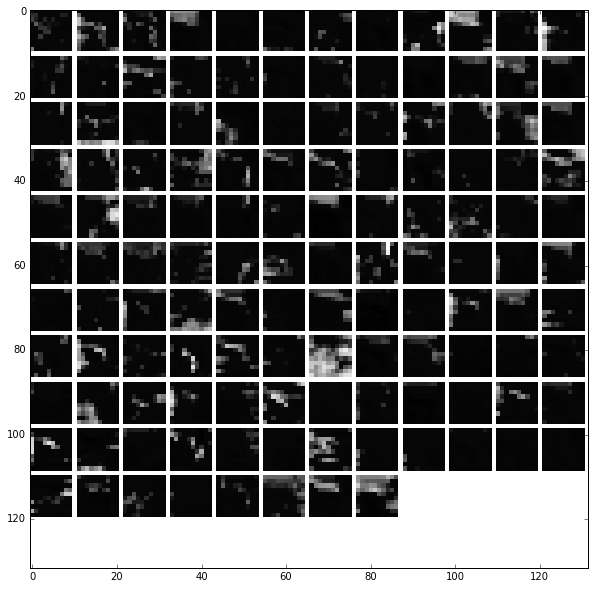

In [14]:
feat = net.blobs['norm2'].data[0]
utils.vis_square(feat, padval=1)

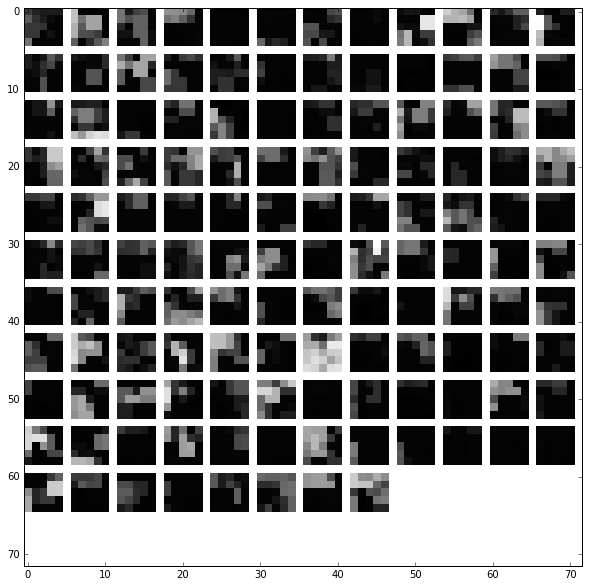

In [15]:
feat = net.blobs['pool2'].data[0]
utils.vis_square(feat, padval=1)

## Layer 3

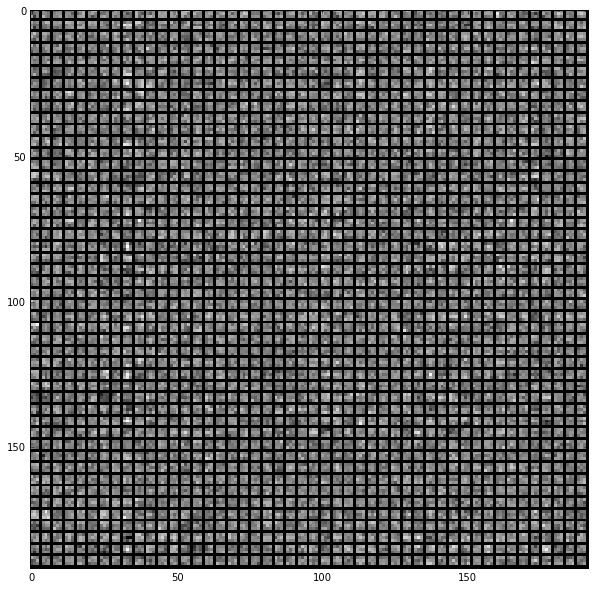

In [16]:
filters = net.params['conv3'][0].data
utils.vis_square(filters[:48, :48].reshape(48**2, 3, 3))

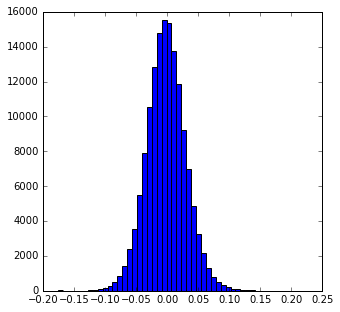

In [17]:
fig, ax = plt.subplots()
ax.hist(filters.ravel(), bins=50)
fig.set_size_inches(5, 5)

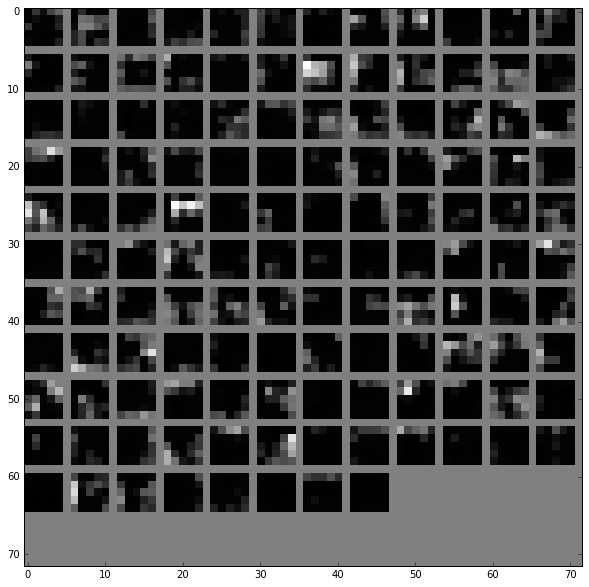

In [18]:
feat = net.blobs['conv3'].data[0]
utils.vis_square(feat, padval=0.5)

## Layer 4

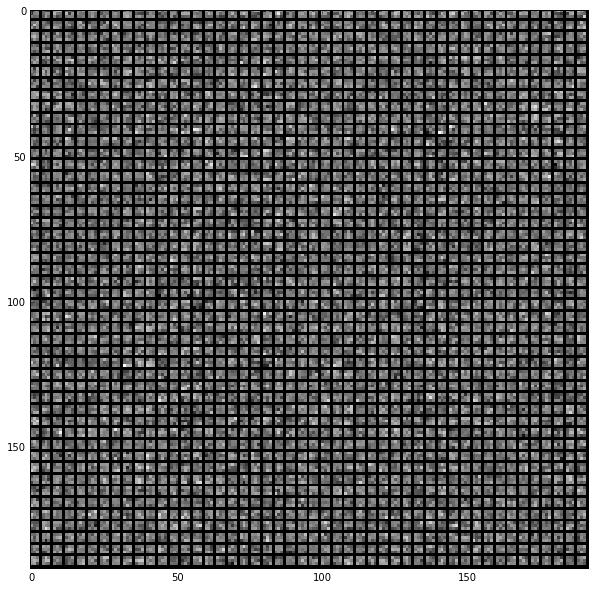

In [19]:
filters = net.params['conv4'][0].data
utils.vis_square(filters[:48, :48].reshape(48**2, 3, 3))

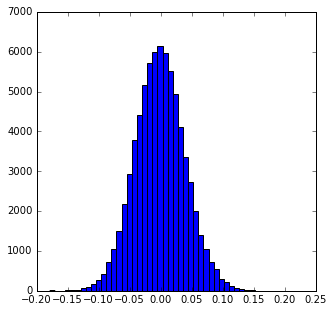

In [20]:
fig, ax = plt.subplots()
ax.hist(filters.ravel(), bins=50)
fig.set_size_inches(5, 5)

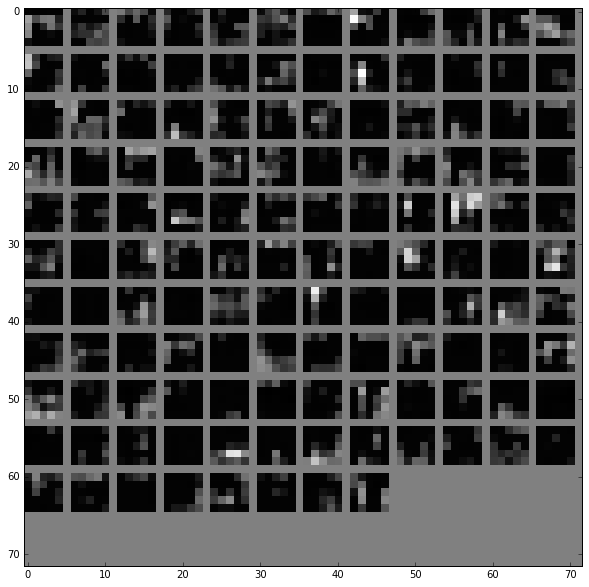

In [21]:
feat = net.blobs['conv4'].data[0]
utils.vis_square(feat, padval=0.5)

## Layer 5

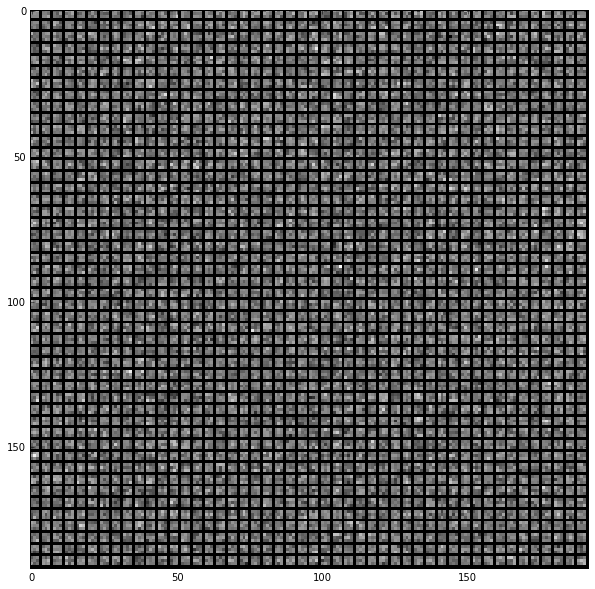

In [22]:
filters = net.params['conv5'][0].data
utils.vis_square(filters[:48, :48].reshape(48**2, 3, 3))

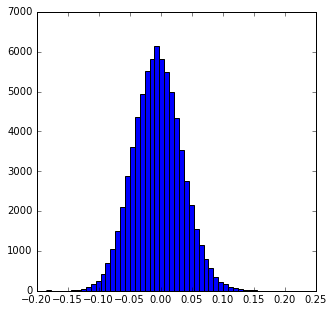

In [23]:
fig, ax = plt.subplots()
ax.hist(filters.ravel(), bins=50)
fig.set_size_inches(5, 5)

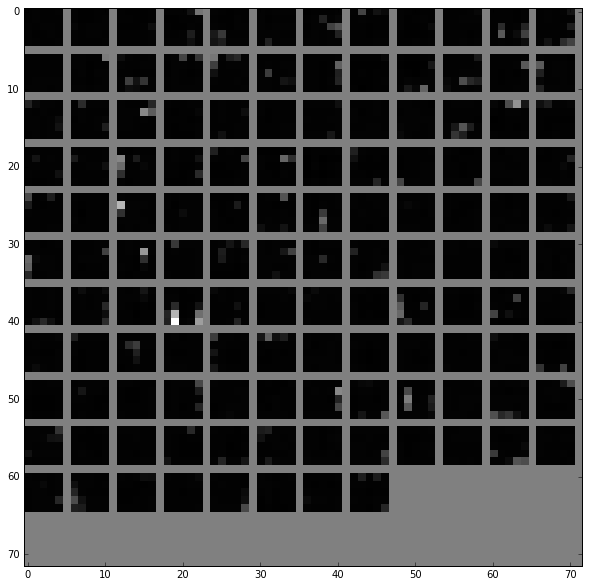

In [24]:
feat = net.blobs['conv5'].data[0]
utils.vis_square(feat, padval=0.5)

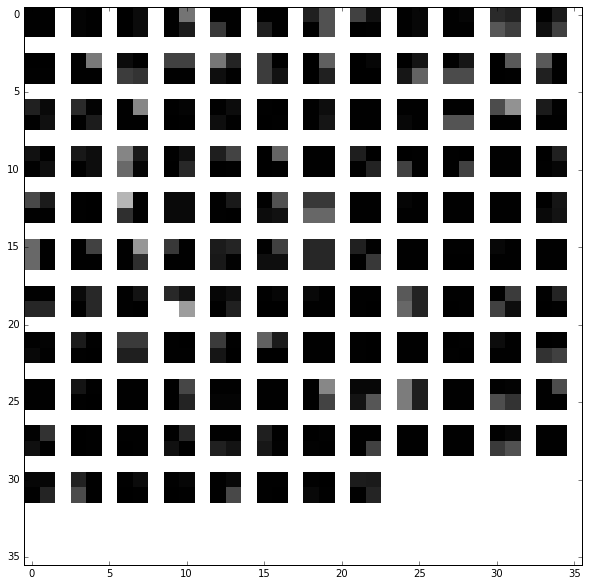

In [25]:
feat = net.blobs['pool5'].data[0]
utils.vis_square(feat, padval=1)

## Layer 6

The first fully connected layer, `fc6`

We show the output values and the histogram of the positive values

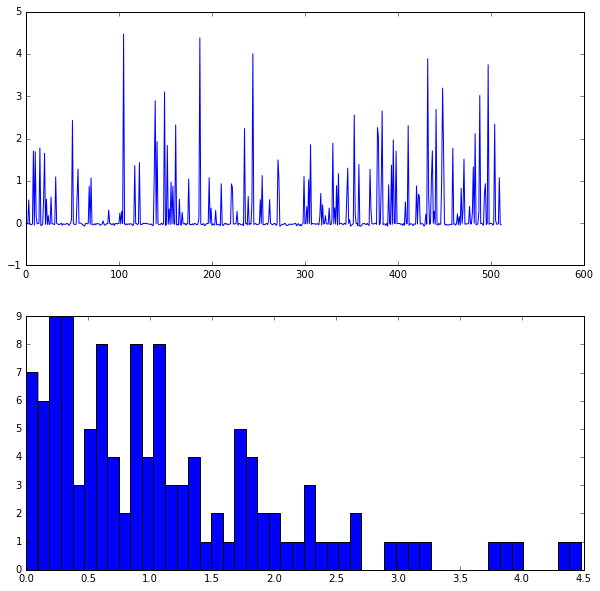

In [26]:
feat = net.blobs['fc6'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=48)

## Layer 7

The second fully connected layer, `fc7`

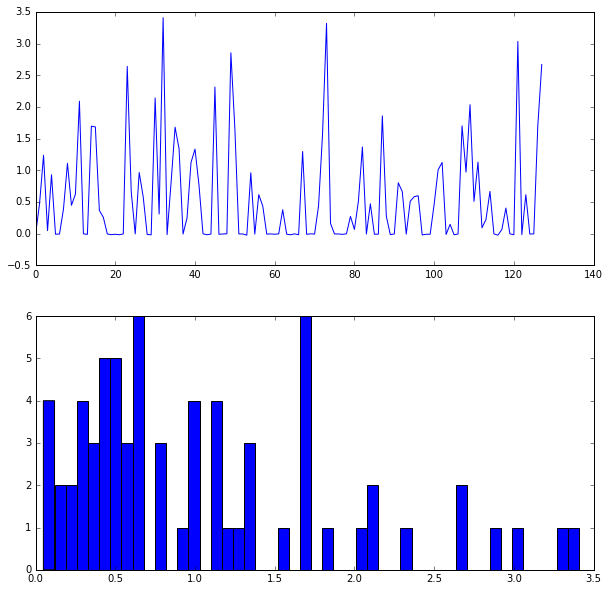

In [27]:
feat = net.blobs['fc7'].data[0]
plt.subplot(2, 1, 1)
plt.plot(feat.flat)
plt.subplot(2, 1, 2)
_ = plt.hist(feat.flat[feat.flat > 0], bins=48)

## Output layer

The final probability output, `prob`

(-0.5, 100.5)

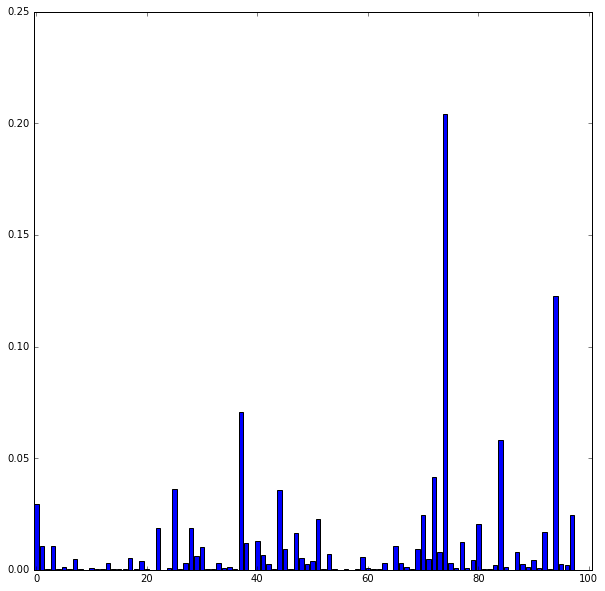

In [28]:
feat = net.blobs['probs'].data[0].flat
fig, ax = plt.subplots()
ax.bar(np.arange(len(feat)), feat, align='center')
ax.set_xlim(-0.5, 100.5)